# FloPy

## Making Maps of Your Model
This notebook demonstrates the mapping capabilities of FloPy. It demonstrates these capabilities by loading and running existing models and then showing how the PlotMapView object and its methods can be used to make nice plots of the model grid, boundary conditions, model results, shape files, etc.

### Mapping is demonstrated for MODFLOW-2005, MODFLOW-USG, and MODFLOW-6 models in this notebook


In [1]:
import sys
import os
import platform
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# run installed version of flopy or add local path
try:
    import flopy
except:
    fpth = os.path.abspath(os.path.join('..', '..'))
    sys.path.append(fpth)
    import flopy

print(sys.version)
print('numpy version: {}'.format(np.__version__))
print('matplotlib version: {}'.format(mpl.__version__))
print('flopy version: {}'.format(flopy.__version__))

3.7.9 (default, Sep  1 2020, 07:16:07) [MSC v.1916 32 bit (Intel)]
numpy version: 1.19.2
matplotlib version: 3.3.1
flopy version: 3.3.3


In [2]:
#Set name of MODFLOW exe
#assumes executable is in users path statement

v2005 = 'mf2005'
exe_name_2005 = 'C:\\Users\\ccoro\\GIT\\flo\\flopy\\MF2005.1_12\\bin\\mf2005.exe'

vmf6 = ''
exe_name_mf6 = 'C:\\Users\\ccoro\\GIT\\flo\\flopy\\mf6\\bin\\mf6.exe'

exe_mp = 'mp6.exe'
exe_name_mp = 'C:\\Users\\ccoro\\GIT\\flo\\flopy\\modpath.6_0\\bin\\mp6.exe'

if platform.system() == 'Windows':
    exe_name_2005 += ''
    exe_name_mf6 += ''
    exe_mp += ''

#Set the paths
loadpth = os.path.join('..', 'data', 'freyberg')
modelpth = os.path.join('data')

#make sure modelpth directory exists
if not os.path.exists(modelpth):
    os.makedirs(modelpth)

### Load and Run an Existing MODFLOW-2005 Model
A model called the "Freyberg Model" is located in the loadpth folder.  In the following code block, we load that model, then change into a new workspace (modelpth) where we recreate and run the model.  For this to work properly, the MODFLOW-2005 executable (mf2005) must be in the path.  We verify that it worked correctly by checking for the presence of freyberg.hds and freyberg.cbc.

In [3]:
ml = flopy.modflow.Modflow.load('freyberg.nam', model_ws=loadpth, 
                                exe_name=exe_name_2005, version=v2005)
ml.change_model_ws(new_pth=modelpth)
ml.write_input()
success, buff = ml.run_model()
if not success:
    print ('Something bad happened.')
files = ['freyberg.hds', 'freyberg.cbc']
for f in files:
    if os.path.isfile(os.path.join(modelpth, f)):
        msg = 'Output file located: {}'.format(f)
        print (msg)
    else:
        errmsg = 'Error. Output file cannot be found: {}'.format(f)
        print (errmsg)


changing model workspace...
   data
FloPy is using the following  executable to run the model: C:\Users\ccoro\GIT\flo\flopy\MF2005.1_12\bin\mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: freyberg.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2020/11/23 23:04:57

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2020/11/23 23:04:57
 Elapsed run time:  0.043 Seconds

  Normal termination of simulation
Output file located: freyberg.hds
Output file located: freyberg.cbc


### Create and Run MODPATH 6 model

The MODFLOW-2005 model created in the previous code block will be used to create a endpoint capture zone and pathline analysis for the pumping wells in the model.

In [4]:
mp = flopy.modpath.Modpath6('freybergmp', exe_name= 'C:\\Users\\ccoro\\GIT\\flo\\flopy\\modpath.6_0\\bin\\mp6.exe', 
                           modflowmodel=ml, model_ws=modelpth)
mpbas = flopy.modpath.Modpath6Bas(mp, hnoflo=ml.bas6.hnoflo, hdry=ml.lpf.hdry, 
                                 ibound=ml.bas6.ibound.array, 
                                 prsity=0.2, prsityCB=0.2)
sim = mp.create_mpsim(trackdir='forward', simtype='endpoint', packages='RCH')
mp.write_input()
mp.run_model()

mpp = flopy.modpath.Modpath6('freybergmpp', exe_name= 'C:\\Users\\ccoro\\GIT\\flo\\flopy\\modpath.6_0\\bin\\mp6.exe', 
                            modflowmodel=ml, model_ws=modelpth)
mpbas = flopy.modpath.Modpath6Bas(mpp, hnoflo=ml.bas6.hnoflo, hdry=ml.lpf.hdry, 
                                 ibound=ml.bas6.ibound.array, 
                                 prsity=0.2, prsityCB=0.2)
sim = mpp.create_mpsim(trackdir='backward', simtype='pathline', packages='WEL')
mpp.write_input()
mpp.run_model()

FloPy is using the following  executable to run the model: C:\Users\ccoro\GIT\flo\flopy\modpath.6_0\bin\mp6.exe
Processing basic data ...
Checking head file ...
Checking budget file and building index ...
 
Run particle tracking simulation ...
Processing Time Step     1 Period     1.  Time =  1.00000E+01                                                                       
Particle tracking complete. Writing endpoint file ...                                                                               
End of MODPATH simulation. Normal termination.
FloPy is using the following  executable to run the model: C:\Users\ccoro\GIT\flo\flopy\modpath.6_0\bin\mp6.exe
Processing basic data ...
Checking head file ...
Checking budget file and building index ...
 
Run particle tracking simulation ...
Processing Time Step     1 Period     1.  Time =  1.00000E+01                                                                       
Particle tracking complete. Writing endpoint file ...             

(True, [])

### Creating a Map of the Model Grid
Now that we have a model, we can use the flopy plotting utilities to make maps.  We will start by making a map of the model grid using the `PlotMapView` class and the `plot_grid()` method of that class.

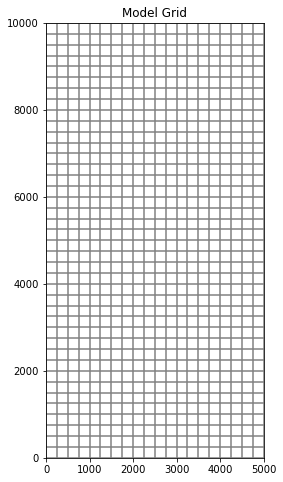

In [5]:
# First step is to set up the plot
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, aspect='equal')

# Next we create an instance of the PlotMapView class
mapview = flopy.plot.PlotMapView(model=ml)

# Then we can use the plot_grid() method to draw the grid
# The return value for this function is a matplotlib LineCollection object,
# which could be manipulated (or used) later if necessary.
linecollection = mapview.plot_grid()

t = ax.set_title("Model Grid")

## Grid transformations and setting coordinate information

The `PlotMapView` class can plot the position of the model grid in space. However, transformations must be done on the modelgrid  using `set_coord_info()`. This allows the user to set the coordinate information once, and then they are able to generate as many instanstances of `PlotMapView` as they wish, without providing the coordinate info again.

Here we demonstrate the effects of these values.  In the first two plots, the grid origin (lower left corner) remains fixed at (0, 0). These first two plots demostrate how work with coordinate info in the `PlotMapView` class. The third example shows the grid origin set at (507000 E, 2927000 N)

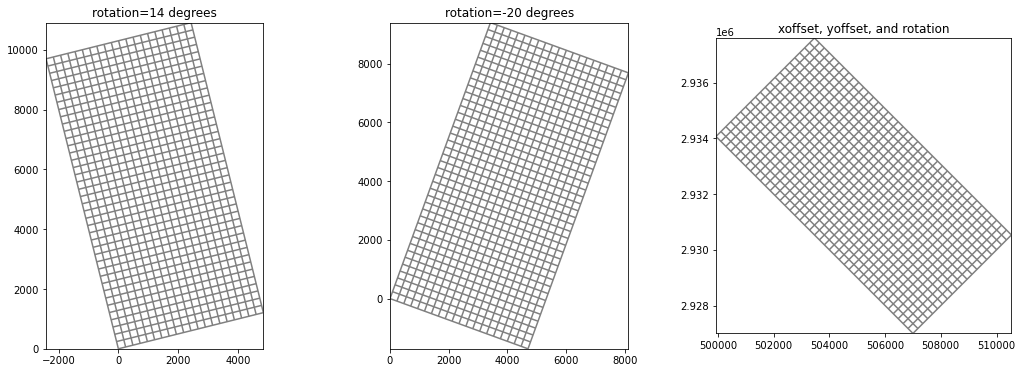

In [6]:
fig = plt.figure(figsize=(18, 6))

ax = fig.add_subplot(1, 3, 1, aspect='equal')

# set modelgrid rotation
ml.modelgrid.set_coord_info(angrot=14)

# generate a plot
mapview = flopy.plot.PlotMapView(model=ml)
linecollection = mapview.plot_grid()
t = ax.set_title('rotation=14 degrees')

# re-set the modelgrid rotation
ml.modelgrid.set_coord_info(angrot=-20)

ax = fig.add_subplot(1, 3, 2, aspect='equal')
mapview = flopy.plot.PlotMapView(model=ml)
linecollection = mapview.plot_grid()
t = ax.set_title('rotation=-20 degrees')

# re-set the modelgrid origin and rotation
ml.modelgrid.set_coord_info(xoff=507000, yoff=2927000, angrot=45)

ax = fig.add_subplot(1, 3, 3, aspect='equal')
mapview = flopy.plot.PlotMapView(model=ml)
linecollection = mapview.plot_grid()
t = ax.set_title("xoffset, yoffset, and rotation")


### Ploting Ibound

The `plot_ibound()` method can be used to plot the boundary conditions contained in the ibound arrray, which is part of the MODFLOW Basic Package.  The `plot_ibound()` method returns a matplotlib QuadMesh object (matplotlib.collections.QuadMesh).  If you are familiar with the matplotlib collections, then this may be important to you, but if not, then don't worry about the return objects of these plotting function.

In [1]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, aspect='equal')

# set the grid rotation and then plot
ml.modelgrid.set_coord_info(angrot=-14)
mapview = flopy.plot.PlotMapView(model=ml)
quadmesh = mapview.plot_ibound()
linecollection = mapview.plot_grid()

NameError: name 'plt' is not defined

We can also change the colors by calling the `color_noflow` and `color_ch` parameters in `plot_ibound()` and the `colors` parameter in `plot_grid()`

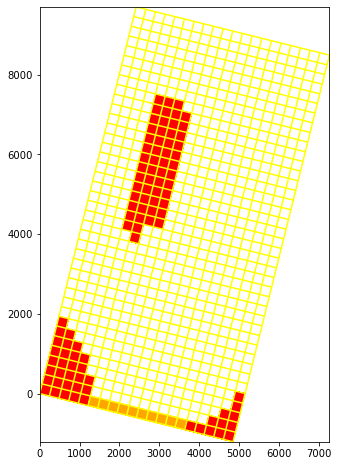

In [8]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
mapview = flopy.plot.PlotMapView(model=ml)
quadmesh = mapview.plot_ibound(color_noflow='red', color_ch='orange')
linecollection = mapview.plot_grid(colors='yellow')

### Plotting Boundary Conditions
The plot_bc() method can be used to plot boundary conditions.  It is setup to use the following dictionary to assign colors, however, these colors can be changed in the method call.

    bc_color_dict = {'default': 'black', 'WEL': 'red', 'DRN': 'yellow',
                 'RIV': 'green', 'GHB': 'cyan', 'CHD': 'navy'}

Here, we plot the location of river cells and the location of well cells.

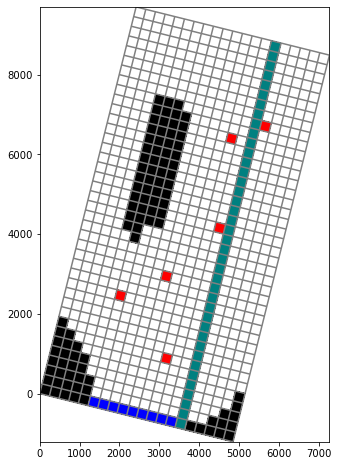

In [9]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
mapview = flopy.plot.PlotMapView(model=ml)
quadmesh = mapview.plot_ibound()
quadmesh = mapview.plot_bc('RIV')
quadmesh = mapview.plot_bc('WEL')
linecollection = mapview.plot_grid()

The colors can be changed by using the `color_noflow` and `color_ch` parameters in `plot_ibound()`, the `color` parameter in `plot_bc()`, and the `colors` parameter in `plot_grid()`

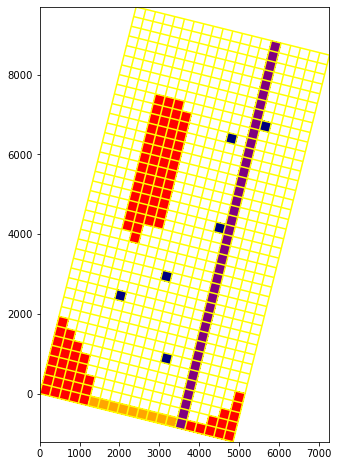

In [10]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
mapview = flopy.plot.PlotMapView(model=ml)
quadmesh = mapview.plot_ibound(color_noflow='red', color_ch='orange')
quadmesh = mapview.plot_bc('RIV', color='purple')
quadmesh = mapview.plot_bc('WEL', color='navy')
linecollection = mapview.plot_grid(colors='yellow')

### Plotting an Array

`PlotMapView` has a `plot_array()` method.  The `plot_array()` method will accept either a 2D or 3D array.  If a 3D array is passed, then the `layer` parameter for the `PlotMapView` object will be used (note that the `PlotMapView` object can be created with a `layer=` argument).

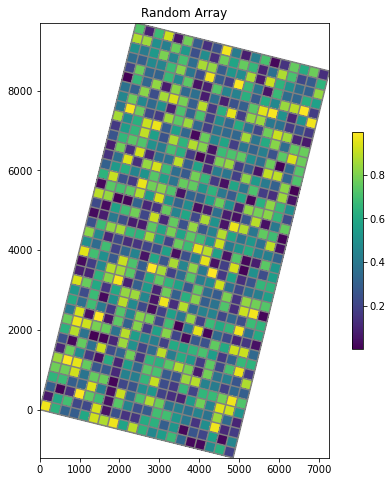

In [11]:
# Create a random array and plot it
a = np.random.random((ml.dis.nrow, ml.dis.ncol))

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
ax.set_title('Random Array')
mapview = flopy.plot.PlotMapView(model=ml, layer=0)
quadmesh = mapview.plot_array(a)
linecollection = mapview.plot_grid()
cb = plt.colorbar(quadmesh, shrink=0.5)

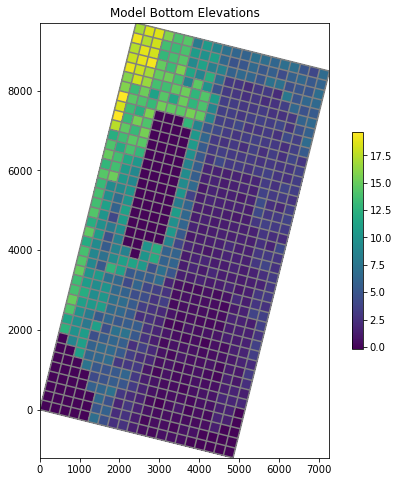

In [12]:
# Plot the model bottom array
a = ml.dis.botm.array

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
ax.set_title('Model Bottom Elevations')
mapview = flopy.plot.PlotMapView(model=ml, layer=0)
quadmesh = mapview.plot_array(a)
linecollection = mapview.plot_grid()
cb = plt.colorbar(quadmesh, shrink=0.5)

### Contouring an Array

`PlotMapView` also has a `contour_array()` method.  It also takes a 2D or 3D array and will contour the layer slice if 3D.

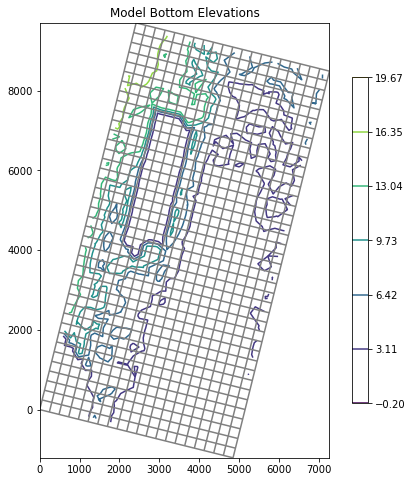

In [13]:
# Contour the model bottom array
a = ml.dis.botm.array

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
ax.set_title('Model Bottom Elevations')
mapview = flopy.plot.PlotMapView(model=ml, layer=0)
contour_set = mapview.contour_array(a)
linecollection = mapview.plot_grid()

plt.colorbar(contour_set, shrink=0.75);

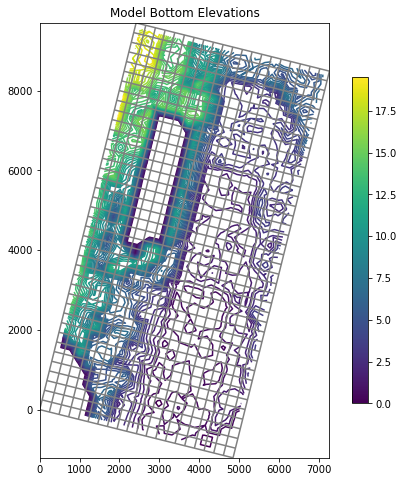

In [14]:
# The contour_array() method will take any keywords
# that can be used by the matplotlib.pyplot.contour
# function. So we can pass in levels, for example.
a = ml.dis.botm.array
levels = np.arange(0, 20, 0.5)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
ax.set_title('Model Bottom Elevations')
mapview = flopy.plot.PlotMapView(model=ml, layer=0)
contour_set = mapview.contour_array(a, levels=levels)
linecollection = mapview.plot_grid()

# set up and plot a continuous colorbar in matplotlib for a contour plot
norm= mpl.colors.Normalize(vmin=contour_set.cvalues.min(), 
                           vmax=contour_set.cvalues.max())
sm = plt.cm.ScalarMappable(norm=norm, cmap=contour_set.cmap)
sm.set_array([])
fig.colorbar(sm, shrink=0.75);

### Plotting Heads

So this means that we can easily plot results from the simulation by extracting heads using `flopy.utils.HeadFile`.  Here we plot the simulated heads.

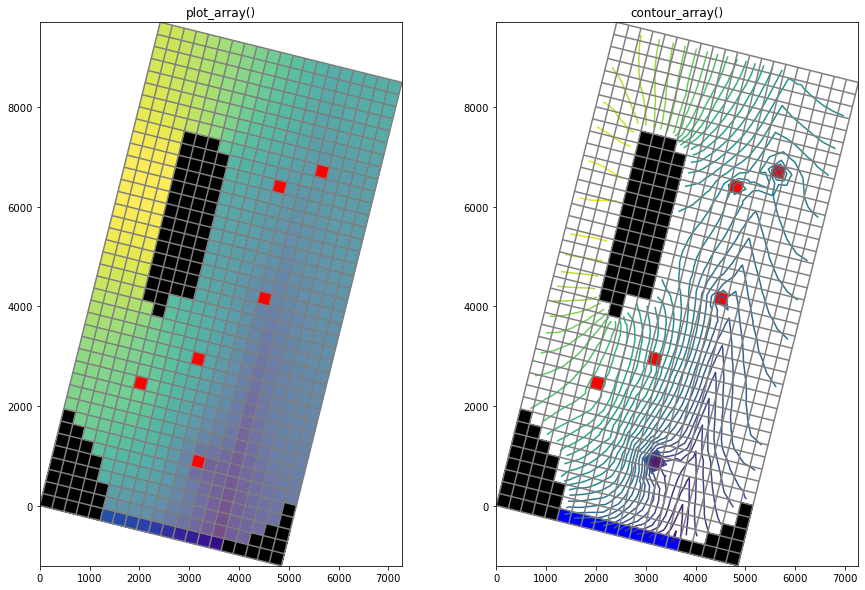

In [15]:
fname = os.path.join(modelpth, 'freyberg.hds')
hdobj = flopy.utils.HeadFile(fname)
head = hdobj.get_data()
levels = np.arange(10, 30, .5)

fig = plt.figure(figsize=(15, 10))

ax = fig.add_subplot(1, 2, 1, aspect='equal')
ax.set_title('plot_array()')
mapview = flopy.plot.PlotMapView(model=ml)
quadmesh = mapview.plot_ibound()
quadmesh = mapview.plot_array(head, masked_values=[999.], alpha=0.5)
mapview.plot_bc("WEL")
linecollection = mapview.plot_grid()

ax = fig.add_subplot(1, 2, 2, aspect='equal')
ax.set_title('contour_array()')
mapview = flopy.plot.PlotMapView(model=ml)
quadmesh = mapview.plot_ibound()
mapview.plot_bc("WEL")
contour_set = mapview.contour_array(head, masked_values=[999.], levels=levels)
linecollection = mapview.plot_grid()

### Plotting Discharge Vectors

`PlotMapView` has a `plot_discharge()` method, which takes the 'FLOW RIGHT FACE' and 'FLOW FRONT FACE' arrays, which can be written by MODFLOW to the cell by cell flow file.  These array can be extracted from the cell by cell flow file using the `flopy.utils.CellBudgetFile` object as shown below.  Once they are extracted, they can be passed to the `plot_discharge()` method.  

**Note**: `plot_discharge()` also takes the head array as an optional argument.  The head array is used by `plot_discharge()` to convert the volumetric discharge in dimensions of $L^3/T$ to specific discharge in dimensions of $L/T$.

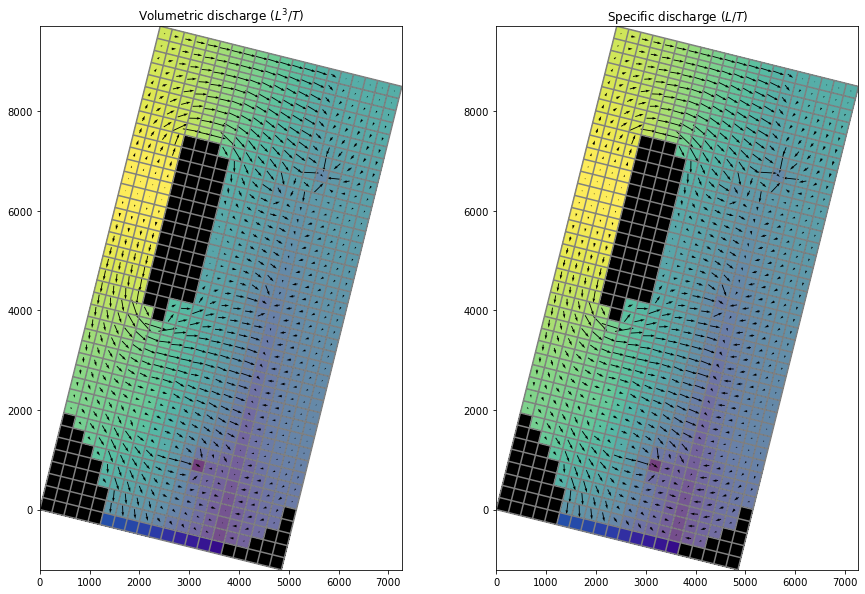

In [16]:
fname = os.path.join(modelpth, 'freyberg.cbc')
cbb = flopy.utils.CellBudgetFile(fname)
frf = cbb.get_data(text='FLOW RIGHT FACE')[0]
fff = cbb.get_data(text='FLOW FRONT FACE')[0]

fig = plt.figure(figsize=(15, 10))

ax = fig.add_subplot(1, 2, 1, aspect='equal')
ax.set_title('Volumetric discharge (' + r'$L^3/T$' + ')')
mapview = flopy.plot.PlotMapView(model=ml)
quadmesh = mapview.plot_ibound()
quadmesh = mapview.plot_array(head, masked_values=[999.], alpha=0.5)
quiver = mapview.plot_discharge(frf, fff)  # no head array for volumetric discharge
linecollection = mapview.plot_grid()

ax = fig.add_subplot(1, 2, 2, aspect='equal')
ax.set_title('Specific discharge (' + r'$L/T$' + ')')
mapview = flopy.plot.PlotMapView(model=ml)
quadmesh = mapview.plot_ibound()
quadmesh = mapview.plot_array(head, masked_values=[999.], alpha=0.5)
quiver = mapview.plot_discharge(frf, fff, head=head)  # include the head array for specific discharge
linecollection = mapview.plot_grid()

### Plotting MODPATH endpoints and pathlines

`PlotMapView` has a `plot_endpoint()` and `plot_pathline()` method, which takes MODPATH endpoint and pathline data and plots them on the map object. Here we load the endpoint and pathline data and plot them on the head and discharge data previously plotted. Pathlines are shown for all times less than or equal to 200 years. Recahrge capture zone data for all of the pumping wells are plotted as circle markers colored by travel time.

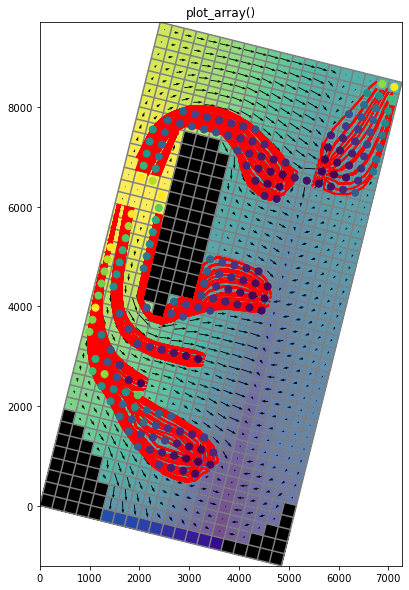

In [17]:
# load the endpoint data
endfile = os.path.join(modelpth, mp.sim.endpoint_file)
endobj = flopy.utils.EndpointFile(endfile)
ept = endobj.get_alldata()

# load the pathline data
pthfile = os.path.join(modelpth, mpp.sim.pathline_file)
pthobj = flopy.utils.PathlineFile(pthfile)
plines = pthobj.get_alldata()

# plot the data
fig = plt.figure(figsize=(10, 10))

ax = fig.add_subplot(1, 1, 1, aspect='equal')
ax.set_title('plot_array()')
mapview = flopy.plot.PlotMapView(model=ml)
quadmesh = mapview.plot_ibound()
quadmesh = mapview.plot_array(head, masked_values=[999.], alpha=0.5)
quiver = mapview.plot_discharge(frf, fff, head=head)
linecollection = mapview.plot_grid()
for d in ml.wel.stress_period_data[0]:
    mapview.plot_endpoint(ept, direction='starting', 
                          selection_direction='ending', 
                          selection=(d[0], d[1], d[2]), zorder=100)

# construct maximum travel time to plot (200 years - MODFLOW time unit is seconds)
travel_time_max = 200. * 365.25 * 24. * 60. * 60. 
ctt = '<={}'.format(travel_time_max)

# plot the pathlines
mapview.plot_pathline(plines, layer='all', colors='red', travel_time=ctt);

### Plotting a Shapefile

`PlotMapView` has a `plot_shapefile()` method that can be used to quickly plot a shapefile on your map.  In order to use the `plot_shapefile()` method, you must be able to  "import shapefile".  The command `import shapefile` is part of the pyshp package.

The `plot_shapefile()` function can plot points, lines, and polygons and will return a patch_collection of objects from the shapefile.  For a shapefile of polygons, the `plot_shapefile()` function will try to plot and fill them all using a different color.  For a shapefile of points, you may need to specify a radius, in model units, in order for the circles to show up properly.

The shapefile must have intersecting geographic coordinates as the `PlotMapView` object in order for it to overlay correctly on the plot.  The `plot_shapefile()` method and function do not use any of the projection information that may be stored with the shapefile.  If you reset `xoff`, `yoff`, and `angrot` in the `ml.modelgrid.set_coord_info()` call below, you will see that the grid will no longer overlay correctly with the shapefile.

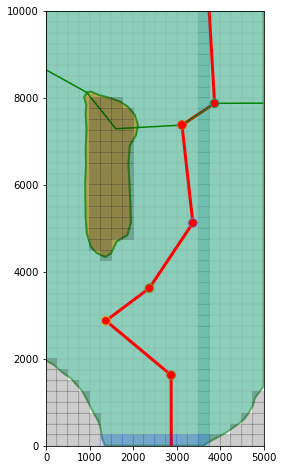

In [18]:
# Setup the figure and PlotMapView. Show a very faint map of ibound and 
# model grid by specifying a transparency alpha value.
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, aspect='equal')

# reset the grid rotation and offsets to 0
ml.modelgrid.set_coord_info(xoff=0, yoff=0, angrot=0)

mapview = flopy.plot.PlotMapView(model=ml,ax=ax)

# Plot a shapefile of 
shp = os.path.join(loadpth, 'gis', 'bedrock_outcrop_hole')
patch_collection = mapview.plot_shapefile(shp, #facecolor='none', 
                                          edgecolor='green', linewidths=2, alpha=0.5)
# Plot a shapefile of a cross-section line
shp = os.path.join(loadpth, 'gis', 'cross_section')
patch_collection = mapview.plot_shapefile(shp, radius=0, lw=[3, 1.5], 
                                          edgecolor=['red', 'green'], facecolor='None')

# Plot a shapefile of well locations
shp = os.path.join(loadpth, 'gis', 'wells_locations')
patch_collection = mapview.plot_shapefile(shp, radius=100, facecolor='red')

# Plot the grid and boundary conditions over the top
quadmesh = mapview.plot_ibound(alpha = 0.1)
quadmesh = mapview.plot_bc('RIV', alpha=0.1)
linecollection = mapview.plot_grid(alpha=0.1)

Although the `PlotMapView`'s `plot_shapefile()` method does not consider projection information when plotting maps, it can be used to plot shapefiles when a `PlotMapView` instance is rotated and offset into geographic coordinates. The same shapefiles plotted above (but in geographic coordinates rather than model coordinates) are plotted on the rotated model grid. The offset from model coordinates to geographic coordinates relative to the lower left corner are `xoff=-2419.22`, `yoff=297.04` and the rotation angle is 14$^{\circ}$.

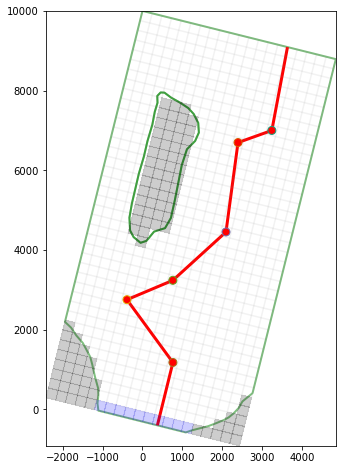

In [19]:
# Setup the figure and PlotMapView. Show a very faint map of ibound and 
# model grid by specifying a transparency alpha value.

# set the modelgrid rotation and offset
ml.modelgrid.set_coord_info(xoff=-2419.2189559966773, yoff=297.0427372400354, angrot=-14)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
mapview = flopy.plot.PlotMapView(model=ml)

# Plot a shapefile of 
shp = os.path.join(loadpth, 'gis', 'bedrock_outcrop_hole_rotate14')
patch_collection = mapview.plot_shapefile(shp, facecolor='none', 
                                           edgecolor='green', linewidths=2, alpha=0.5)
# Plot a shapefile of a cross-section line
shp = os.path.join(loadpth, 'gis', 'cross_section_rotate14')
patch_collection = mapview.plot_shapefile(shp, radius=0, lw=3, 
                                          edgecolor='red', facecolor='None')

# Plot a shapefile of well locations
shp = os.path.join(loadpth, 'gis', 'wells_locations_rotate14')
patch_collection = mapview.plot_shapefile(shp, radius=100, facecolor='red')

# Plot the grid and boundary conditions over the top
quadmesh = mapview.plot_ibound(alpha = 0.1)
linecollection = mapview.plot_grid(alpha=0.1);

## Working with MODFLOW-6 models

`PlotMapView` has support for MODFLOW-6 models and operates in the same fashion for Structured Grids, Vertex Grids, and Unstructured Grids. Here is a short example on how to plot with MODFLOW-6 structured grids using a version of the Freyberg model created for MODFLOW-6

In [20]:
# load the Freyberg model into mf6-flopy and run the simulation
sim_name = 'mfsim.nam'
sim_path = os.path.join("..", "data", "mf6-freyberg")
sim = flopy.mf6.MFSimulation.load(sim_name=sim_name, version=vmf6, exe_name= 'C:\\Users\\ccoro\\GIT\\flo\\flopy\\mf6\\bin\\mf6.exe', 
                                  sim_ws=sim_path)

newpth = os.path.join('data')
sim.set_sim_path(newpth)
sim.write_simulation()
success, buff = sim.run_simulation()
if not success:
    print ('Something bad happened.')
files = ['freyberg.hds', 'freyberg.cbc']
for f in files:
    if os.path.isfile(os.path.join(modelpth, f)):
        msg = 'Output file located: {}'.format(f)
        print (msg)
    else:
        errmsg = 'Error. Output file cannot be found: {}'.format(f)
        print (errmsg)

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package ic...
    loading package oc...
    loading package npf...
    loading package sto...
    loading package chd...
    loading package riv...
    loading package wel...
    loading package rch...
  loading ims package gwf_1...
writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package gwf_1...
  writing model gwf_1...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package oc...
    writing package npf...
    writing package sto...
    writing package chd_0...
    writing package riv_0...
    writing package wel_0...
    writing package rch_0...
FloPy is using the following  executable to run the model: C:\Users\ccoro\GIT\flo\flopy\mf6\bin\mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODUL

### Plotting boundary conditions and arrays

This works the same as modflow-2005, however the simulation object can host a number of modflow-6 models so we need to grab a model before attempting to plot with `PlotMapView`

Exception: Not a list-style boundary package: 'MFTransientList' object is not subscriptable

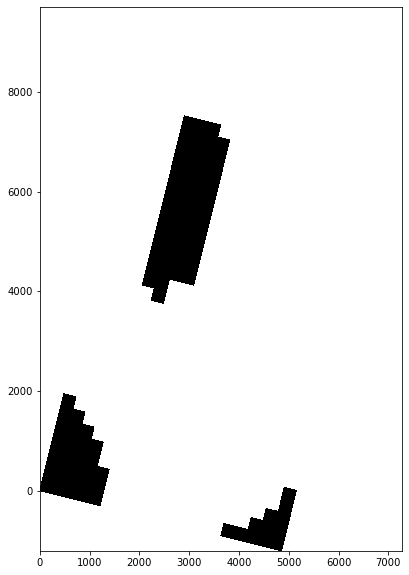

In [21]:
# get the modflow-6 model we want to plot
ml6 = sim.get_model('gwf_1')
ml6.modelgrid.set_coord_info(angrot=-14)

fig = plt.figure(figsize=(15, 10))

# plot boundary conditions
ax = fig.add_subplot(1, 2, 1, aspect='equal')
mapview = flopy.plot.PlotMapView(model=ml6)
quadmesh = mapview.plot_ibound()
quadmesh = mapview.plot_bc('RIV')
quadmesh = mapview.plot_bc('WEL')
linecollection = mapview.plot_grid()
ax.set_title("Plot boundary conditions")

# plot model bottom elevations
a = ml6.dis.botm.array

ax = fig.add_subplot(1, 2, 2, aspect='equal')
ax.set_title('Model Bottom Elevations')
mapview = flopy.plot.PlotMapView(model=ml6, layer=0)
quadmesh = mapview.plot_array(a)
inactive = mapview.plot_inactive()
linecollection = mapview.plot_grid()
cb = plt.colorbar(quadmesh, shrink=0.5)


### Contouring Arrays

Contouring arrays follows the same code signature for MODFLOW-6 as the MODFLOW-2005 example. Just use the `contour_array()` method

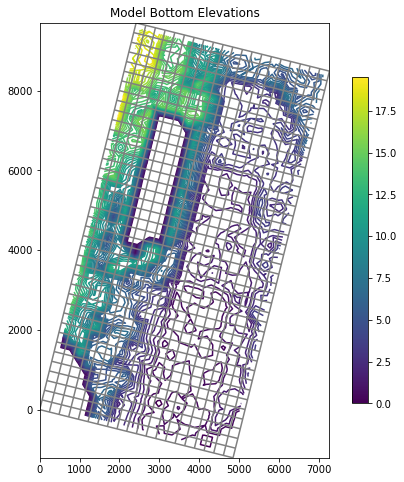

In [22]:
# The contour_array() method will take any keywords that can be used by the matplotlib.pyplot.contour function. 
# So we can pass in levels, for example.
a = ml6.dis.botm.array
levels = np.arange(0, 20, 0.5)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
ax.set_title('Model Bottom Elevations')
mapview = flopy.plot.PlotMapView(model=ml6, layer=0)
contour_set = mapview.contour_array(a, levels=levels)
linecollection = mapview.plot_grid()

# set up and plot a continuous colorbar in matplotlib for a contour plot
norm= mpl.colors.Normalize(vmin=contour_set.cvalues.min(), 
                           vmax=contour_set.cvalues.max())
sm = plt.cm.ScalarMappable(norm=norm, cmap=contour_set.cmap)
sm.set_array([])
fig.colorbar(sm, shrink=0.75);

### Plotting specific discharge with a MODFLOW-6 model

MODFLOW-6 includes a the PLOT_SPECIFIC_DISCHARGE flag in the NPF package to calculate and store discharge vectors for easy plotting. `PlotMapView` has the `plot_specific_discharge()` method to use this data. The specific discharge array is stored in the cell budget file.

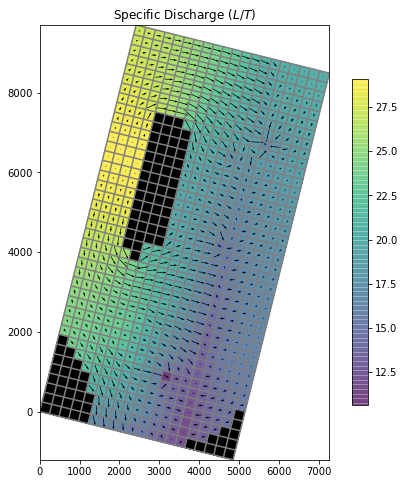

In [23]:
# get the specific discharge from the cell budget file
cbc_file = os.path.join(newpth, "freyberg.cbc")
cbc = flopy.utils.CellBudgetFile(cbc_file, precision='double')
spdis = cbc.get_data(text="SPDIS")

# get the head from the head file
head_file = os.path.join(newpth, "freyberg.hds")
head = flopy.utils.HeadFile(head_file)
hdata = head.get_alldata()[0]

# plot specific discharge using PlotMapView
fig = plt.figure(figsize=(8, 8))

mapview = flopy.plot.PlotMapView(model=ml6, layer=0)
linecollection = mapview.plot_grid()
quadmesh = mapview.plot_array(a=hdata, alpha=0.5, masked_values=[1e30])
quiver = mapview.plot_specific_discharge(spdis[0])
inactive = mapview.plot_inactive()

plt.title("Specific Discharge (" + r'$L/T$' + ')')
plt.colorbar(quadmesh, shrink=0.75);


## Vertex model plotting with MODFLOW-6

FloPy fully supports vertex discretization (DISV) plotting through the `PlotMapView` class. The method calls are identical to the ones presented previously for Structured discretization (DIS) and the same matplotlib keyword arguments are supported. Let's run through an example using a vertex model grid.

In [24]:
# build and run vertex model grid demo problem
sys.path.append(os.path.join("..", "common"))
import setup_pmv_demo
setup_pmv_demo.run()

3.7.9 (default, Sep  1 2020, 07:16:07) [MSC v.1916 32 bit (Intel)]
numpy version: 1.19.2
matplotlib version: 3.3.1
flopy version: 3.3.3
writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims...
  writing model mp7p2...
    writing model name file...
    writing package disv...
    writing package ic...
    writing package npf...
    writing package wel_0...
INFORMATION: maxbound in ('gwf6', 'wel', 'dimensions') changed to 1 based on size of stress_period_data
    writing package rcha...
    writing package riv_0...
INFORMATION: maxbound in ('gwf6', 'riv', 'dimensions') changed to 21 based on size of stress_period_data
    writing package oc...
FloPy is using the following  executable to run the model: C:\Users\ccoro\GIT\flo\flopy\mf6\bin\mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.2.0 10/22/2020

   MODFLOW 6 comp

TypeError: __init__() got an unexpected keyword argument 'flowmodel'

In [ ]:
# check if model ran properly
modelpth = os.path.join("data", "mp7_ex2", "mf6")
files = ['mp7p2.hds', 'mp7p2.cbb']
for f in files:
    if os.path.isfile(os.path.join(modelpth, f)):
        msg = 'Output file located: {}'.format(f)
        print (msg)
    else:
        errmsg = 'Error. Output file cannot be found: {}'.format(f)
        print (errmsg)

In [ ]:
# load the simulation and get the model
vertex_sim_name = "mfsim.nam"
vertex_sim = flopy.mf6.MFSimulation.load(sim_name=vertex_sim_name, version=vmf6, exe_name=exe_name_mf6, 
                                         sim_ws=modelpth)
vertex_ml6 = vertex_sim.get_model("mp7p2")

### Setting MODFLOW-6 Vertex Model Grid offsets, rotation and plotting

Setting the `Grid` offsets and rotation is consistent in FloPy, no matter which type of discretization the user is using. The `set_coord_info()` method on the `modelgrid` is used.  

Plotting works consistently too, the user just calls the `PlotMapView` class and it accounts for the discretization type

In [ ]:
# set coordinate information on the modelgrid
vertex_ml6.modelgrid.set_coord_info(xoff=362100, yoff=4718900, angrot=-21)

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
ax.set_title("Vertex Model Grid (DISV)")

# use PlotMapView to plot a DISV (vertex) model
mapview = flopy.plot.PlotMapView(vertex_ml6, layer=0)
linecollection = mapview.plot_grid()

### Plotting boundary conditions with Vertex Model grids

The `plot_bc()` method can be used to plot boundary conditions.  It is setup to use the following dictionary to assign colors, however, these colors can be changed in the method call.

    bc_color_dict = {'default': 'black', 'WEL': 'red', 'DRN': 'yellow',
                     'RIV': 'green', 'GHB': 'cyan', 'CHD': 'navy'}

Here we plot river (RIV) cell locations

In [ ]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
ax.set_title("Vertex Model Grid (DISV)")

# use PlotMapView to plot a DISV (vertex) model
mapview = flopy.plot.PlotMapView(vertex_ml6, layer=0)
riv = mapview.plot_bc("RIV")
linecollection = mapview.plot_grid()

### Plotting Arrays and Contouring with Vertex Model grids

`PlotMapView` allows the user to plot arrays and contour with DISV based discretization. The `plot_array()` method is called in the same way as using a structured grid. The only difference is that `PlotMapView` builds a matplotlib patch collection for Vertex based grids. 

In [ ]:
# get the head output for stress period 1 from the modflow6 head file
head = flopy.utils.HeadFile(os.path.join(modelpth, 'mp7p2.hds'))
hdata = head.get_alldata()[0, :, :, :]

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
ax.set_title("plot_array()")

mapview = flopy.plot.PlotMapView(model=vertex_ml6, layer=2)
patch_collection = mapview.plot_array(hdata, cmap="Dark2")
linecollection = mapview.plot_grid(lw=0.25, color='k')
cb = plt.colorbar(patch_collection, shrink=0.75)

The `contour_array()` method operates in the same way as the sturctured example.

In [ ]:
# plotting head array and then contouring the array!
levels = np.arange(327, 332, 0.5)

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
ax.set_title('Model head contours, layer 3')

mapview = flopy.plot.PlotMapView(model=vertex_ml6, layer=2)
pc = mapview.plot_array(hdata, cmap="Dark2")

# contouring the head array
contour_set = mapview.contour_array(hdata, levels=levels, colors='white')
plt.clabel(contour_set, fmt='%.1f', colors='white', fontsize=11)
linecollection = mapview.plot_grid(lw=0.25, color='k')

cb = plt.colorbar(pc, shrink=0.75)

### Plotting MODPATH 7 results on a vertex model

MODPATH-7 results can be plotted using the same built in methods as used previously to plot MODPATH-6 results. The `plot_pathline()` and `plot_timeseries()` methods are layered on the previous example to show modpath simulation results

In [ ]:
# load the MODPATH-7 results
mp_namea = 'mp7p2a_mp'
fpth = os.path.join(modelpth, mp_namea + ".mppth")
p = flopy.utils.PathlineFile(fpth)
p0 = p.get_alldata()

fpth = os.path.join(modelpth, mp_namea + '.timeseries')
ts = flopy.utils.TimeseriesFile(fpth)
ts0 = ts.get_alldata()

In [ ]:
# setup the plot
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
ax.set_title('MODPATH 7 particle tracking results')

mapview = flopy.plot.PlotMapView(vertex_ml6, layer=2)

# plot and contour head arrays
pc = mapview.plot_array(hdata, cmap="Dark2")
contour_set = mapview.contour_array(hdata, levels=levels, colors='white')
plt.clabel(contour_set, fmt='%.1f', colors='white', fontsize=11)
linecollection = mapview.plot_grid(lw=0.25, color='k')
cb = plt.colorbar(pc, shrink=0.75)

# plot the modpath results
pline = mapview.plot_pathline(p0, layer='all', color='blue', lw=0.75)
colors = ['green', 'orange', 'red']
for k in range(3):
    tseries = mapview.plot_timeseries(ts0, layer=k, marker='o', lw=0, color=colors[k])

### Plotting specific discharge vectors for DISV
MODFLOW-6 includes a the PLOT_SPECIFIC_DISCHARGE flag in the NPF package to calculate and store discharge vectors for easy plotting. `PlotMapView` has the `plot_specific_discharge()` method to use this data. The specific discharge array is stored in the cell budget file.

In [ ]:
cbb = flopy.utils.CellBudgetFile(os.path.join(modelpth, 'mp7p2.cbb'), precision='double')
spdis = cbb.get_data(text="SPDIS")

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
ax.set_title('Specific discharge for vertex model')

mapview = flopy.plot.PlotMapView(vertex_ml6, layer=2)
pc = mapview.plot_array(hdata, cmap="Dark2")
linecollection = mapview.plot_grid(lw=0.25, color='k')
cb = plt.colorbar(pc, shrink=0.75)

# plot specific discharge
quiver = mapview.plot_specific_discharge(spdis[0], normalize=True, alpha=0.60)

## Unstructured grid (DISU) plotting with MODFLOW-USG and MODFLOW-6

Unstructured grid (DISU) plotting has support through the `PlotMapView` class and the `UnstructuredGrid` discretization object. The method calls are identical to those used for vertex (DISV) and structured (DIS) model grids. Let's run through a few unstructured grid examples

In [ ]:
# set up the notebook for unstructured grid plotting
from flopy.discretization import UnstructuredGrid

# this is a folder containing some unstructured grids
datapth = os.path.join('..', 'data', 'unstructured')

# simple functions to load vertices and incidence lists
def load_verts(fname):
    return(np.genfromtxt(fname))

def load_iverts(fname):
    f = open(fname, 'r')
    iverts = []
    xc = []
    yc = []
    for line in f:
        ll = line.strip().split()
        iverts.append([int(i) - 1 for i in ll[4:]])
        xc.append(float(ll[1]))
        yc.append(float(ll[2]))
    return iverts, np.array(xc), np.array(yc)

In [ ]:
# load vertices
fname = os.path.join(datapth, 'ugrid_verts.dat')
verts = load_verts(fname)[:, 1:]

# load the incidence list into iverts
fname = os.path.join(datapth, 'ugrid_iverts.dat')
iverts, xc, yc = load_iverts(fname)

In this case, verts is just a 2-dimensional list of x,y vertex pairs.  iverts is also a 2-dimensional list, where the outer list is of size ncells, and the inner list is a list of the vertex numbers that comprise the cell.

In [ ]:
# Print the first 5 entries in verts and iverts
for ivert, v in enumerate(verts[:5]):
    print('Vertex coordinate pair for vertex {}: {}'.format(ivert, v))
print('...\n')
    
for icell, vertlist in enumerate(iverts[:5]):
    print('List of vertices for cell {}: {}'.format(icell, vertlist))

A flopy `UnstructuredGrid` object can now be created using the vertices and incidence list.  The `UnstructuredGrid` object is a key part of the plotting capabilities in flopy.  In addition to the vertex information, the `UnstructuredGrid` object also needs to know how many cells are in each layer.  This is specified in the ncpl variable, which is a list of cells per layer.

In [ ]:
ncpl = np.array(5 * [len(iverts)])
umg = UnstructuredGrid(verts, iverts, xc, yc, ncpl=ncpl)
print(ncpl)
print(umg)

Now that we have an `UnstructuredGrid`, we can use the flopy `PlotMapView` object to create different types of plots, just like we do for structured grids.

In [ ]:
f = plt.figure(figsize=(10, 10))
mapview = flopy.plot.PlotMapView(modelgrid=umg)
mapview.plot_grid()
plt.plot(umg.xcellcenters, umg.ycellcenters, 'bo');

In [ ]:
# Create a random array for layer 0, and then plot it with a color flood and contours
f = plt.figure(figsize=(10, 10))

a = np.random.random((ncpl[0])) * 100
levels = np.arange(0, 100, 30)

mapview = flopy.plot.PlotMapView(modelgrid=umg)
pc = mapview.plot_array(a, cmap='viridis')
contour_set = mapview.contour_array(a, levels=levels, colors='white')
plt.clabel(contour_set, fmt='%.1f', colors='white', fontsize=11)
linecollection = mapview.plot_grid(color='k', lw=0.5)
colorbar = plt.colorbar(pc, shrink=0.75)

Here are some examples of some other types of grids.  The data files for these grids are located in the datapth folder.

In [ ]:
fig = plt.figure(figsize=(10, 30))
fnames = [fname for fname in os.listdir(datapth) if fname.endswith('.exp')]
nplot = len(fnames)
for i, f in enumerate(fnames):
    ax = fig.add_subplot(nplot, 1, i + 1, aspect='equal')
    fname = os.path.join(datapth, f)
    umga = UnstructuredGrid.from_argus_export(fname, nlay=1)
    mapview = flopy.plot.PlotMapView(modelgrid=umga, ax=ax)
    linecollection = mapview.plot_grid(colors='sienna')
    ax.set_title(fname)

## Summary

This notebook demonstrates some of the plotting functionality available with FloPy.  Although not described here, the plotting functionality tries to be general by passing keyword arguments passed to `PlotMapView` methods down into the `matplotlib.pyplot` routines that do the actual plotting.  For those looking to customize these plots, it may be necessary to search for the available keywords by understanding the types of objects that are created by the `PlotMapView` methods.  The `PlotMapView` methods return these `matplotlib.collections` objects so that they could be fine-tuned later in the script before plotting.

Hope this gets you started!